## Introduction 

According to the National Centre for Health Statistics, there are more than 40 million cases of asthma or chronic obstructive pulmonary disease (COPD) in the United States (U.S.). Around 12 million people have not yet been diagnosed with COPD [1][2]. The costs associated with such common respiratory diseases include healthcare costs, productivity loss, higher insurance premiums and higher tax expenses. Based on historical estimates from National Institutes of Health, National Heart, Lung, and Blood Institute (NHLBI), the annual health care expenditures for asthma alone are estimated at $20.7 billion [3][4]. Timely and accurate, detection, intervention and treatment of respiratory diseases not only can help to improve patient's outcomes, it can also help to reduce the cost to individuals and the society. 

Chest X-ray (CXR) exam is one of the most common and cost-effective diagnostic tools in diagnosing lung diseases. It can be used to detect cancer, infection or air collecting in the space around a lung. It can also show chronic lung conditions, such as emphysema or cystic fibrosis, as well as complications related to these conditions. However clinical diagnosis of chest X-ray can be challenging, and sometimes believed to be harder than diagnosis via chest CT imaging. Even some promising work have been reported in the past, and especially in recent deep learning work on Tuberculosis (TB) classification. Achieving clinically relevant computer-aided detection and diagnosis (CAD) in real world medical sites on all data settings of CXR is still a very challenging, if not impossible feat when only several thousands of images are employed for study. This is evident from  where the performance deep neural networks for thorax disease recognition is severely limited by the availability of only 4,143 frontal view images (Openi is the previous largest publicly available chest X-ray dataset to date). Although CAD has been used in clinical environments for over 40 years, CAD usually does not substitute the doctor or other professional, but rather plays a supporting role. A radiologist is generally responsible for the final interpretation of a medical image and closing the report.

## Objectives

In this project, I aim to achieve the following:

1. Build a convolutional neural network (CNN) model to perform a multi-label classification of thoracic pathology using CXR images and,
2. Evaluate its performance against transfer learning approaches such as ResNet50 and MobileNetV2 models with metrics such as macro-average recall and F1 score.


## Methodology

The original dataset is extracted from the clinical Picture Archiving and Communcation System (PACS) database at National Institutes of Health Clinical Center in the United States (U.S.). It consists of 112,120 of all frontal chest x-ray images of 30,085 unique patients in the hospital. Compared to other publicly available datasets, this dataset is significantly more representative to the real patient population distributions and realistic clinical diagnosis challenges in the U.S. Fourteen disease image labels (where each image can have multi-labels) were mined from the associated radiological reports using natural language processing. The labels represent common thoracic pathologies and they include Atelectasis, Consolidation, Infiltration, Pneumothorax, Edema, Emphysema, Fibrosis, Effusion, Pneumonia, Pleural_thickening, Cardiomegaly, Nodule, Mass and Hernia. 

Image labels with less than 1,000 counts were removed.CXR Images are divided into train/validation and testing by patient level. All studies from the same patient will only appear in either training/validation or testing set. Lablels with normal results (i.e. ‘No Finding’) are removed to reduce sparseness of the target matrix. The final train-validation dataset contains 36,023 samples with thirteen labels, less Hernia.

## **Load Libraries**

In [3]:
from skimage.io import imread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

## **Load Data**

In [17]:
data_dir = "../data"
labels = pd.read_csv(f'{data_dir}/Data_Entry_2017.csv')


In [5]:
# Display first 5 rows of labels data frame
labels.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [6]:
# Check for any missing value and data type
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  object 
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(4), object(5)
memory usage: 10.3+ MB


In [18]:
# Create new column to concatenate image path and image name
labels['image_path'] = f'{data_dir}/images-224/images-224/' + labels['Image Index']

In [19]:
# Retain numerical values in 'Patient Age' column
labels['Patient Age'] = labels['Patient Age'].map(lambda x: int(x[:-1]))

In [20]:
# Display top 15 values in 'Finding Labels' column
label_counts = labels['Finding Labels'].value_counts()[:15]
label_counts

No Finding                  60412
Infiltration                 9551
Atelectasis                  4212
Effusion                     3959
Nodule                       2706
Pneumothorax                 2199
Mass                         2138
Effusion|Infiltration        1602
Atelectasis|Infiltration     1356
Consolidation                1314
Atelectasis|Effusion         1167
Pleural_Thickening           1127
Cardiomegaly                 1094
Emphysema                     895
Infiltration|Nodule           829
Name: Finding Labels, dtype: int64

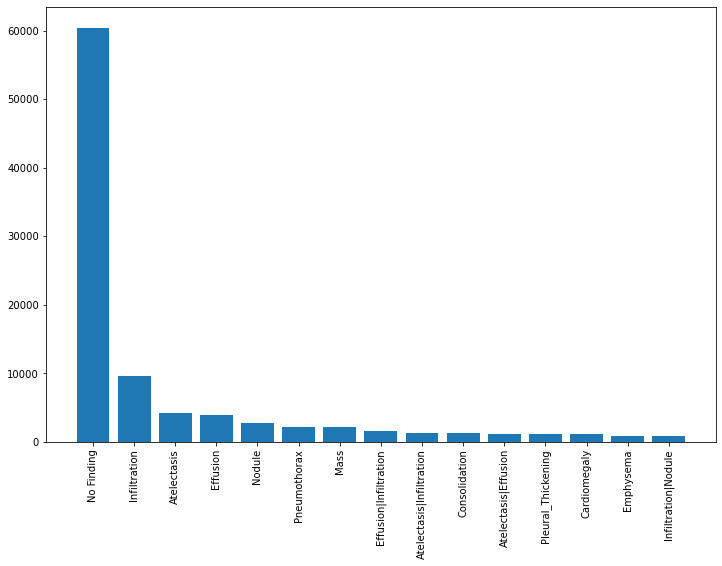

In [21]:
# Bar plot of top 15 values in 'Finding Labels'
label_counts = labels['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [22]:
# Replace 'No Finding' with '' in 'Finding Labels' column
labels['Finding Labels'] = labels['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

In [23]:
# Store unique values in 'Finding Labels' column in an array
all_labels = np.unique(list(chain(*labels['Finding Labels'].map(
             lambda x: x.split('|')).tolist()))
)

In [24]:
# Store non-null unique values in all_labels in a list
all_labels = [x for x in all_labels if len(x)>0]
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [25]:
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [26]:
for cleaned_label in all_labels:
  if len(cleaned_label)>0:
    labels[cleaned_label] = labels['Finding Labels'].map(lambda finding: 1 if cleaned_label in finding else 0).astype(int)

In [28]:
# Open trainval txt and store elements in a list
with open(f'{data_dir}/train_val_list_NIH.txt', 'r') as f:    
    train_val_list = f.readlines()
    train_val_list = [x[:-1] for x in train_val_list]

In [29]:
# Create a new column to split train and test dataset
labels['type'] = labels['Image Index'].map(
                 lambda name: 'train' if name in train_val_list else 'test'
)

In [30]:
# Drop irrelevant columns
labels.drop(['Follow-up #','Patient Age','Patient Gender','OriginalImage[Width', 
             'Height]','OriginalImagePixelSpacing[x','y]', 'Unnamed: 11','View Position'],
            axis = 1, inplace=True)

In [31]:
labels.head()

,Image Index,Finding Labels,Patient ID,image_path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,type
0,00000001_000.png,Cardiomegaly,1,data/images-224/images-224/00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,train
1,00000001_001.png,Cardiomegaly|Emphysema,1,data/images-224/images-224/00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,train
2,00000001_002.png,Cardiomegaly|Effusion,1,data/images-224/images-224/00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,train
3,00000002_000.png,,2,data/images-224/images-224/00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train
4,00000003_000.png,Hernia,3,data/images-224/images-224/00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,test


In [32]:
# Store train and test data frame separately 
train_labels = labels[labels['type'] == 'train']
test_labels = labels[labels['type'] == 'test']

In [33]:
# Filter null values from 'Finding Labels' column to reduce sparseness of target matrix 
train_labels = train_labels[train_labels['Finding Labels'] != '']

In [34]:
# Reset index 
train_labels.reset_index(drop= True, inplace= True)
test_labels.reset_index(drop= True, inplace= True)

### **Visualize balance of each of the labels**

In [35]:
columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 
           'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
df = train_labels[columns]

In [36]:
df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36018,0,0,1,0,0,0,0,0,0,0,0,0,0
36019,0,0,1,0,0,0,0,0,0,0,1,0,0
36020,0,0,0,0,0,0,0,1,0,0,0,0,0
36021,0,0,0,0,0,0,0,0,1,1,0,0,0


In [37]:
df_melt = pd.melt(df)
df_melt

,variable,value
0,Atelectasis,0
1,Atelectasis,0
2,Atelectasis,0
3,Atelectasis,0
4,Atelectasis,0
...,...,...
468294,Pneumothorax,0
468295,Pneumothorax,0
468296,Pneumothorax,0
468297,Pneumothorax,0


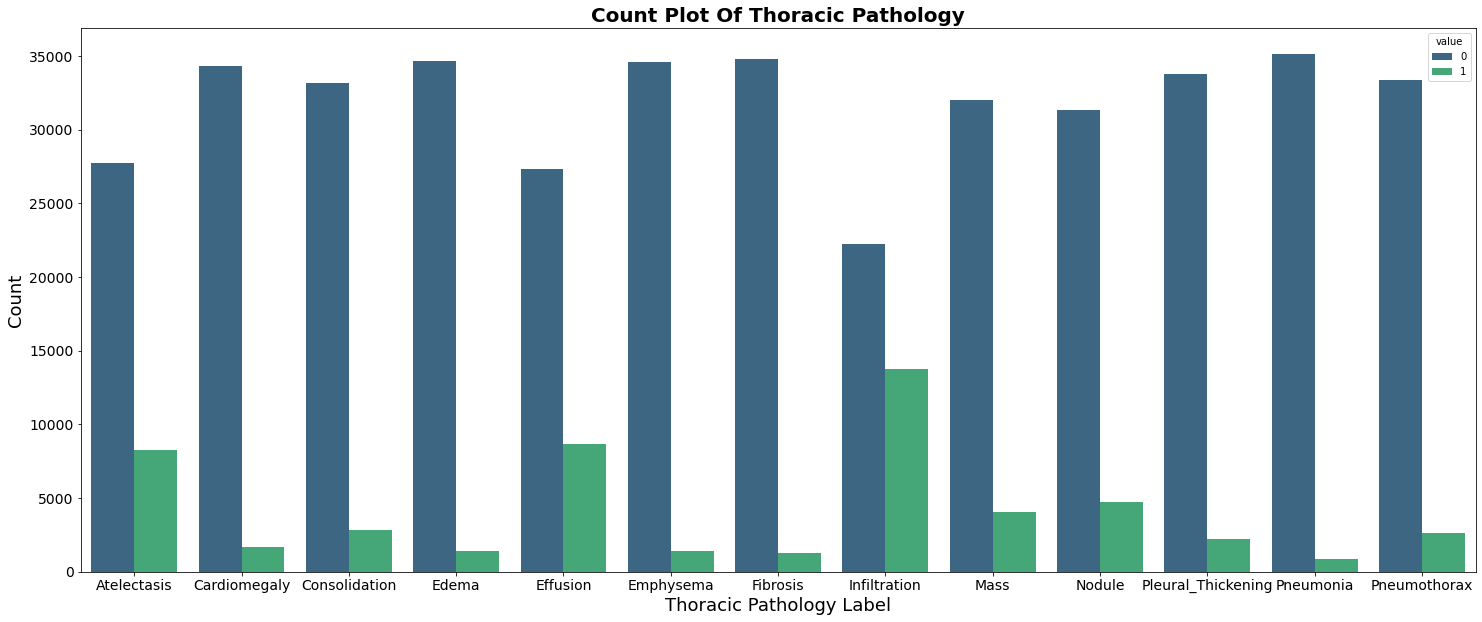

In [38]:
plt.figure(figsize=(25, 10))
sns.countplot(x="variable", hue="value", data=df_melt, palette='viridis')
plt.title('Count Plot Of Thoracic Pathology', fontweight='bold', fontsize=20)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Thoracic Pathology Label', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### **Visualize sample images with single label**

The spatial dimensions of a CXR are usually 2,000 by 3,000 pixels. Local pathological image regions can show hugely varying sizes or extents but often very small comparing to the full image scale. Below are plots of sample images with single labels.

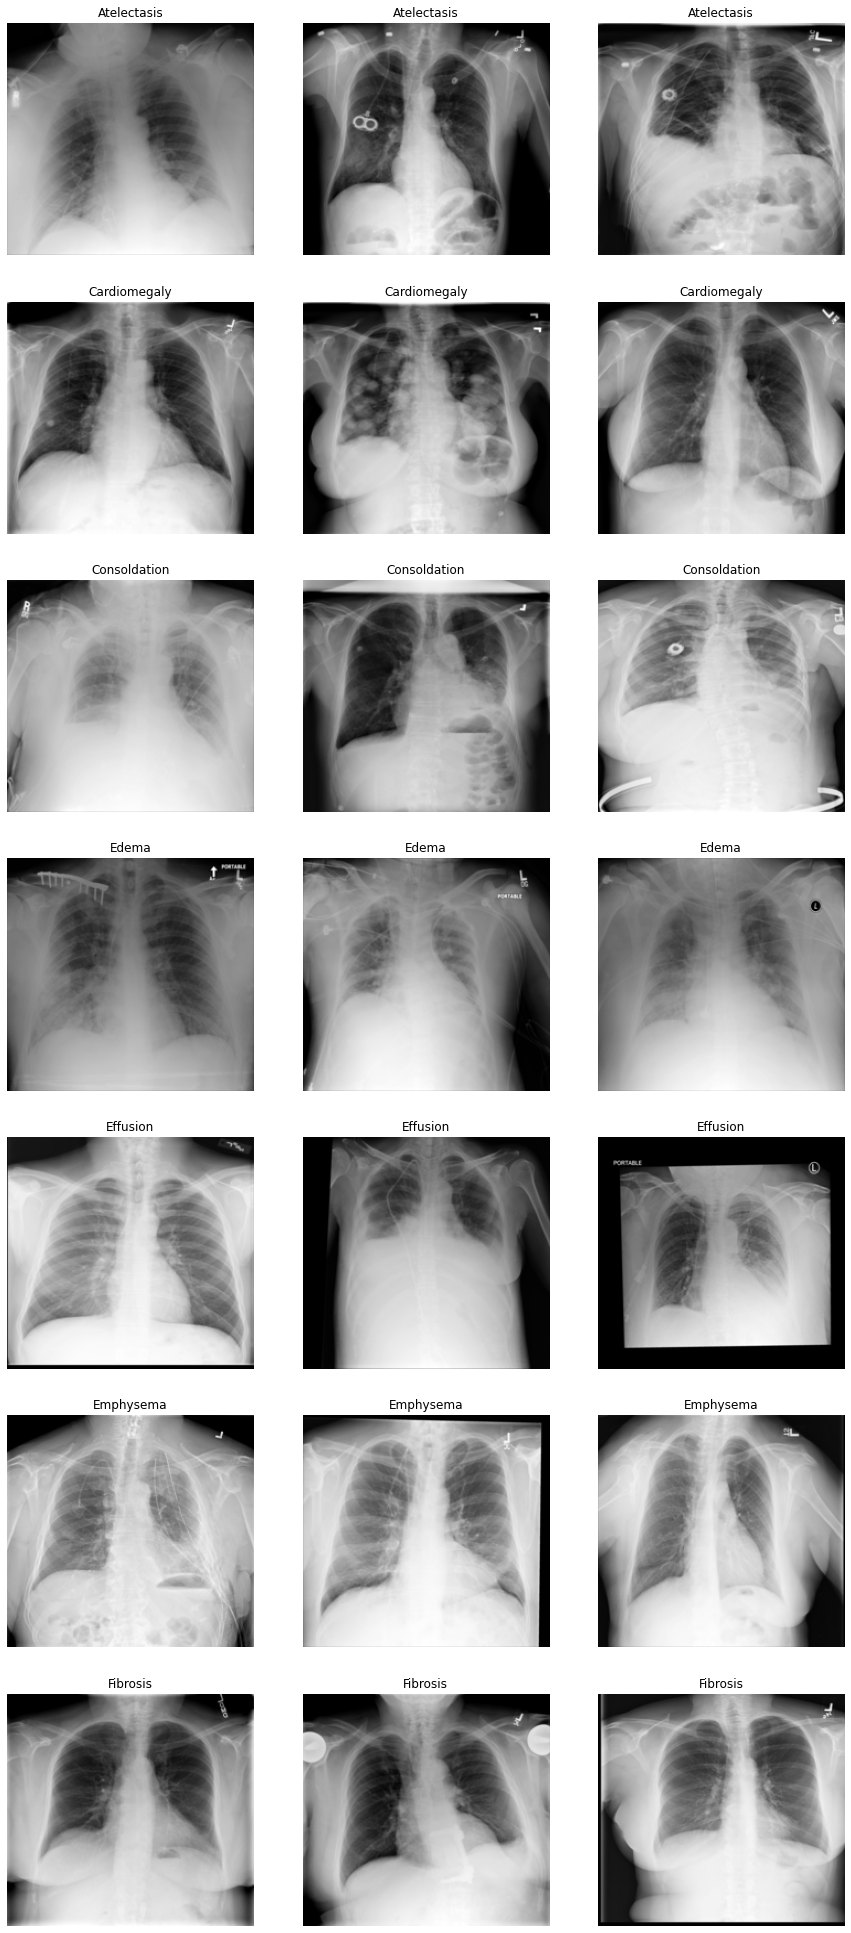

In [39]:
# Sample 3 images for the first seven labels
Atelectasis = (train_labels[train_labels['Finding Labels']=='Atelectasis']['image_path'].sample(3)).tolist()
Cardiomegaly = (train_labels[train_labels['Finding Labels']=='Cardiomegaly']['image_path'].sample(3)).tolist()
Consolidation = (train_labels[train_labels['Finding Labels']=='Consolidation']['image_path'].sample(3)).tolist()
Edema = (train_labels[train_labels['Finding Labels']=='Edema']['image_path'].sample(3)).tolist() 
Effusion = (train_labels[train_labels['Finding Labels']=='Effusion']['image_path'].sample(3)).tolist() 
Emphysema = (train_labels[train_labels['Finding Labels']=='Emphysema']['image_path'].sample(3)).tolist() 
Fibrosis = (train_labels[train_labels['Finding Labels']=='Fibrosis']['image_path'].sample(3)).tolist() 


# Initiate plots 
fig, ax = plt.subplots(7,3, figsize = (15,35))

# Iterate through 13 sets of 3 images
for i in range(3):
    
    # Read images
    atelectasis = imread(Atelectasis[i])
    cardiomegaly = imread(Cardiomegaly[i])
    consoldation = imread(Consolidation[i])
    edema = imread(Edema[i])
    effusion = imread(Effusion[i])
    emphysema = imread(Emphysema[i])
    fibrosis = imread(Fibrosis[i])

    
    # View images
    ax[0, i].imshow(atelectasis, cmap = 'gray')
    ax[1, i].imshow(cardiomegaly, cmap = 'gray')
    ax[2, i].imshow(consoldation, cmap = 'gray')
    ax[3, i].imshow(edema, cmap = 'gray')
    ax[4, i].imshow(effusion, cmap = 'gray')
    ax[5, i].imshow(emphysema, cmap = 'gray')
    ax[6, i].imshow(fibrosis, cmap = 'gray')


    # Labels
    ax[0, i].set_title('Atelectasis')
    ax[1, i].set_title('Cardiomegaly')
    ax[2, i].set_title('Consoldation')
    ax[3, i].set_title('Edema')
    ax[4, i].set_title('Effusion')
    ax[5, i].set_title('Emphysema')
    ax[6, i].set_title('Fibrosis')
    
  
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[3, i].axis('off')
    ax[4, i].axis('off')
    ax[5, i].axis('off')
    ax[6, i].axis('off')

    ax[0, i].set_aspect('auto')
    ax[1, i].set_aspect('auto')
    ax[2, i].set_aspect('auto')
    ax[3, i].set_aspect('auto')
    ax[4, i].set_aspect('auto')
    ax[5, i].set_aspect('auto')
    ax[6, i].set_aspect('auto');


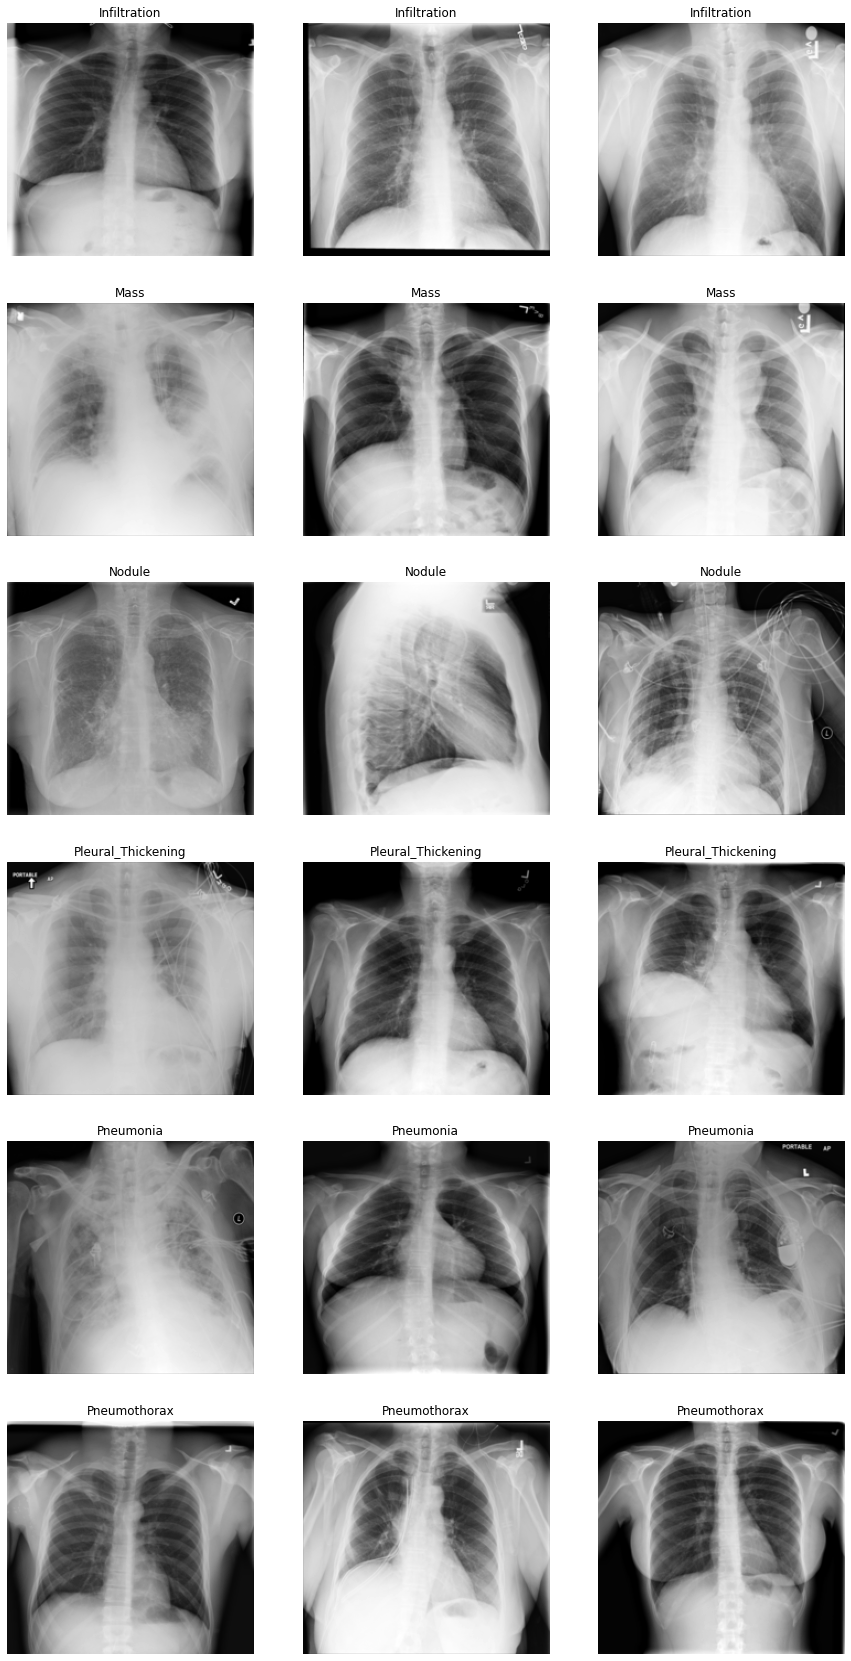

In [40]:
# Sample 3 images for the remaining six labels
Infiltration = (train_labels[train_labels['Finding Labels']=='Infiltration']['image_path'].sample(3)).tolist()
Mass = (train_labels[train_labels['Finding Labels']=='Mass']['image_path'].sample(3)).tolist() 
Nodule = (train_labels[train_labels['Finding Labels']=='Nodule']['image_path'].sample(3)).tolist() 
Pleural_Thickening = (train_labels[train_labels['Finding Labels']=='Pleural_Thickening']['image_path'].sample(3)).tolist()
Pneumonia = (train_labels[train_labels['Finding Labels']=='Pneumonia']['image_path'].sample(3)).tolist()
Pneumothorax = (train_labels[train_labels['Finding Labels']=='Pneumothorax']['image_path'].sample(3)).tolist()


# Initiate plots 
fig, ax = plt.subplots(6,3, figsize = (15,30))

# Iterate through 13 sets of 3 images
for i in range(3):
    
    # Read images
    infiltration = imread(Infiltration[i])
    mass = imread(Mass[i])
    nodule = imread(Nodule[i])
    pleural_thickening = imread(Pleural_Thickening[i])
    pneumonia = imread(Pneumonia[i])
    pneumothorax = imread(Pneumothorax[i])
    
    # View images
    ax[0, i].imshow(infiltration, cmap = 'gray')
    ax[1, i].imshow(mass, cmap = 'gray')
    ax[2, i].imshow(nodule, cmap = 'gray')
    ax[3, i].imshow(pleural_thickening, cmap = 'gray')
    ax[4, i].imshow(pneumonia, cmap = 'gray')
    ax[5, i].imshow(pneumothorax, cmap = 'gray')

    # Labels
    ax[0, i].set_title('Infiltration')
    ax[1, i].set_title('Mass')
    ax[2, i].set_title('Nodule')
    ax[3, i].set_title('Pleural_Thickening')
    ax[4, i].set_title('Pneumonia')
    ax[5, i].set_title('Pneumothorax')
  
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[3, i].axis('off')
    ax[4, i].axis('off')
    ax[5, i].axis('off')

    ax[0, i].set_aspect('auto')
    ax[1, i].set_aspect('auto')
    ax[2, i].set_aspect('auto')
    ax[3, i].set_aspect('auto')
    ax[4, i].set_aspect('auto')
    ax[5, i].set_aspect('auto');
                                  

From the CXR images above, it is an arduous task for the untrained eye to discern and correctly identify single thoracic pathology label, let alone multiple labels. This reinforces my motivation of using deep learning models to perform multi-label classification.

In [41]:
# Final check to ensure there is no missing values
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36023 entries, 0 to 36022
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image Index         36023 non-null  object
 1   Finding Labels      36023 non-null  object
 2   Patient ID          36023 non-null  int64 
 3   image_path          36023 non-null  object
 4   Atelectasis         36023 non-null  int64 
 5   Cardiomegaly        36023 non-null  int64 
 6   Consolidation       36023 non-null  int64 
 7   Edema               36023 non-null  int64 
 8   Effusion            36023 non-null  int64 
 9   Emphysema           36023 non-null  int64 
 10  Fibrosis            36023 non-null  int64 
 11  Hernia              36023 non-null  int64 
 12  Infiltration        36023 non-null  int64 
 13  Mass                36023 non-null  int64 
 14  Nodule              36023 non-null  int64 
 15  Pleural_Thickening  36023 non-null  int64 
 16  Pneumonia           36

In [42]:
# Export train_ data frame as as csv
## train_labels.to_csv('train.csv', index=False)
## test_labels.to_csv('test.csv', index=False)